# EPIG Figure 1

In [ ]:
!conda install -y -c anaconda scikit-learn 

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::widgetsnbextension==3.5.1=py38h578d9bd_4
  - pytorch/linux-64::torchvision==0.8.2=py38_cu110
  - defaults/linux-64::mkl_random==1.1.1=py38h0573a6f_0
  - defaults/linux-64::mkl_fft==1.2.0=py38h23d657b_0
  - defaults/linux-64::jedi==0.17.0=py38_0
  - pytorch/linux-64::pytorch==1.7.1=py3.8_cuda11.0.221_cudnn8.0.5_0
  - pytorch/linux-64::ignite==0.4.2=py38_0
  - pytorch/linux-64::torchaudio==0.7.2=py38
  - conda-forge/linux-64::matplotlib-base==3.3.3=py38h5c7f4ab_0
  - conda-forge/noarch::ipywidgets==7.5.1=pyh9f0ad1d_1
  - conda-forge/linux-64::notebook==6.1.5=py38h578d9bd_0
  - defaults/linux-64::numpy==1.19.2=py38h54aff64_0
  - conda-forge/noarch::ipympl==0.5.8=pyh9f0ad1d_0
done

## Package Plan ##

  environment location: /home/blackhc/anaconda3/envs/active_learning

  added / updated specs:
    - scikit-learn



In [ ]:
import itertools
import numpy as np

from scipy.stats import multivariate_normal
from scipy.stats import norm

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
def sample(x, f, noise_f):
    y = f(x)
    stddev_x = noise_f(x)    
    noise = np.random.normal(0, stddev_x)
    y += noise
        
    return y, stddev_x

def sample_and_fit_gp(x, f, noise_f):
    y, stddev_x = sample(x, f, noise_f)    
    gp = fit_gp(x, y, stddev_x)
    
    return gp, y, stddev_x


def fit_gp(x, y, std):
    x = np.asarray(x)
    y = np.asarray(y)
    std = np.asarray(std)
    
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
    kernel = RBF(1, (1e-2, 1e2))
    #kernel = RBF(0.1, (1e-2, 1e2))
    # Instantiate a Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel, alpha=std ** 2,
                                  n_restarts_optimizer=10)
    
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(x[:, None], y)
    
    return gp

In [ ]:
def plot_stddev(x, y, sigma, axes=None, label='95% confidence interval'):
    if axes is None:
        axes = plt.gca()
        
    axes.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([
                 y - 1.9600 * sigma,
                 (y + 1.9600 * sigma)[::-1]
             ]),
             alpha=.25,
             fc='b',
             ec='None',
             label=label)


In [ ]:
def plot_gp(gp, obs_x, obs_y, obs_stddev, padding=None, axes=None):
    if padding is None:
        padding = PLOT_GP_PADDING
    if axes is None:
        axes = plt.gca()

    obs_x = np.asarray(obs_x)
    obs_y = np.asarray(obs_y)

    x_min = obs_x.min() - padding
    x_max = obs_x.max() + padding

    axes.set_xlim(x_min, x_max)

    x = np.linspace(x_min, x_max, 1000)
    y, sigma = gp.predict(x[:, None], return_std=True)

    axes.errorbar(obs_x,
                 obs_y,
                 obs_stddev,
                 fmt='rx',
                 markersize=10,
                 label=u'Training Data')
    axes.plot(x, y, 'b-', label=u'Prediction')

    plot_stddev(x, y, sigma)

    return x, y, sigma

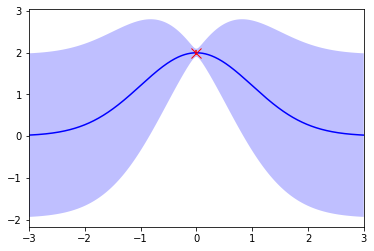

In [ ]:
x = [0]
y = [2]
stddev = 0.05
gp = fit_gp(x, y, stddev)
    
plot_gp(gp, x, y, stddev)

   
plt.show()

In [ ]:
def BALD(gp: GaussianProcessRegressor, x, stddev):
    y_mean, y_stddev = gp.predict([[x]], return_std=True)

    bald_value = norm(scale=y_stddev+stddev).entropy() - norm(scale=stddev).entropy()
    
    return bald_value    

In [ ]:
X = np.arange(-3,3, 0.1)
bald_scores = [BALD(gp, x, stddev) for x in X]

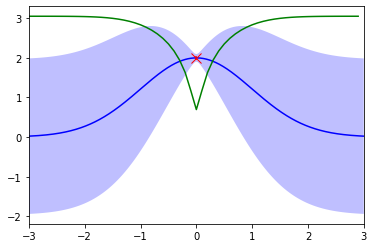

In [ ]:
plot_gp(gp, x, y, stddev)
plt.plot(X, bald_scores, c="g", label="BALD")

In [ ]:
def EPIG(gp: GaussianProcessRegressor, x, x_e, stddev):
    Y_mean, cov = gp.predict([[x], [x_e]], return_cov=True)
    
    cov += np.diag([stddev, stddev])
    
    H_Y = norm(scale=cov[0, 0]**0.5).entropy()
    H_Y_e = norm(scale=cov[1, 1]**0.5).entropy()
        
    H_Y__Y_e = multivariate_normal(Y_mean, cov=cov).entropy()
    
    #print(H_Y, H_Y_e, H_Y__Y_e)
    
    epig_value = H_Y + H_Y_e - H_Y__Y_e
    
    return epig_value

In [ ]:
x_e = -1
epig_scores = [EPIG(gp, x, x_e, stddev) for x in X]

(-2.5, 3.5)

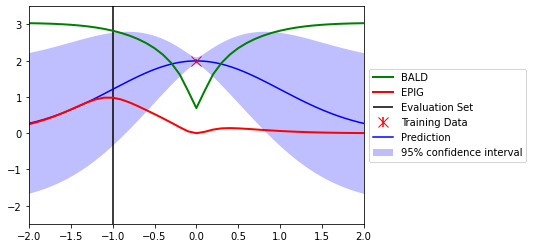

In [ ]:
plot_gp(gp, x, y, stddev)
plt.plot(X, epig_scores, c="r", linewidth=2, label="EPIG")
plt.plot(X, bald_scores, c="g", linewidth=2, label="BALD")
#plt.scatter([x_e], [0], c="black", marker="o")

plt.vlines([x_e], ymin=-4, ymax=4, colors="black", label="Evaluation Set")
handles, labels = plt.gca().get_legend_handles_labels()
hl = list(zip(handles, labels))
hl = [hl[2], hl[1], hl[4], hl[5], hl[0], hl[3]]
handles, labels = list(zip(*hl))
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([-2, 2])
plt.ylim([-2.5, 3.5])